In [1]:
import pandas as pd
from pandas.tools.plotting import scatter_matrix
import numpy as np
from utiles import *
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib
from sklearn.metrics import cohen_kappa_score, make_scorer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA, KernelPCA

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Loading Data

In [2]:
class DataHandler:
    class __DataHandler:
        path = None
        datos = {}
        
        def __init__(self, path):
            self.path = path
        def __str__(self):
            return repr(self) + self.path

        def get_data(self, una_bolsa, one_row=True):
            if una_bolsa in self.datos.keys():
                return self.return_data(una_bolsa, one_row)

            return self.load_data(una_bolsa, one_row)
        
        def return_data(self, una_bolsa, one_row=False):
            bolsa = pd.DataFrame([])
            keys = self.datos[una_bolsa].keys()
            for k in keys:
                df = self.datos[una_bolsa][k]
                bolsa = pd.concat([bolsa, df], ignore_index=True)
            return bolsa
        
        
        def load_data(self, una_bolsa, one_row=False):
            sets = os.listdir(self.path+"/"+una_bolsa)
            if len(sets) != 0:
                self.datos[una_bolsa] = {}
                for s in sets:
                    ruta = "{}/{}/{}".format( self.path, una_bolsa, s)
                    df = pd.read_csv(ruta, index_col=[0], names=["amp"]).T
                    self.datos[una_bolsa][s] = df
                return self.return_data(una_bolsa, one_row)
            print("Error!: No existe la bolsa especificada")
            return
        
        def get_all(self, one_row=True):
            total_data = pd.DataFrame()
            for i, k in enumerate(self.datos.keys()):
                df = self.return_data(k, one_row)
                df["clase"] = k
                total_data = pd.concat([total_data, df], ignore_index=True)
            return total_data
        
        def load_all(self):
            if self.path:
                bolsas = [x.name for x in os.scandir(self.path) if os.path.isdir(x)]
                for b in bolsas:
                    self.load_data(b)
            else:
                print("Path undefined")

        
    instance = None
    def __init__(self, path):
        if not DataHandler.instance:
            DataHandler.instance = DataHandler.__DataHandler(path)
        else:
            DataHandler.instance.path = path
    def __getattr__(self, name):
        return getattr(self.instance, name)

In [3]:
loader = DataHandler("data")
loader.load_all()
data = loader.get_all()

## Preprocessing Data

In [4]:
std = StandardScaler()
target = np.where(data['clase']=='sin adulterar', 0, 1)
normalized = std.fit_transform(data.iloc[:,:-1])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(normalized, target, test_size=.3, random_state=10)

model = LogisticRegression()                          # create the RFE model and select 10 from 1557 attributes
rfe = RFE(model, 5, step=10)
rfe = rfe.fit(X_train, y_train)
# print(rfe.ranking_)                                 # Rank of each feature. 1 means the feature was selected

In [6]:
indices = np.where(rfe.support_)                       # Mask of selected features
new_data = normalized[:, indices[0]]
print("shape of new_data: {}".format(new_data.shape))

shape of new_data: (566, 5)


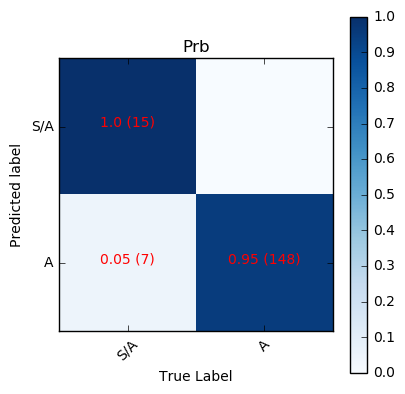

[ 0.78605388  0.37209302  0.91102698]
Cohen's Kappa Score: 0.7886323268206039


In [7]:
clf = RandomForestClassifier(max_depth=6, n_jobs=4, n_estimators=40, criterion="gini", class_weight={0:7,1:.5})
clf.fit(X_train[:, indices[0]], y_train)
p = clf.predict(X_test[:, indices[0]])

kappa_ = make_scorer(cohen_kappa_score)
cm = confusion_matrix(y_pred=p, y_true=y_test)
plot_confusion_matrix(classes=["S/A", "A"], cm=cm, norm=True, title="Prb")
val = cross_val_score(estimator=clf, X=normalized[:, indices[0]], y=target, n_jobs=4, scoring=kappa_)
print(val)
print("Cohen's Kappa Score: {}".format(cohen_kappa_score(y_test, p)))

In [8]:
# pca = KernelPCA(n_components=5, random_state=15, kernel="poly", degree=2, gamma=.1) # linear, poly, rbf, sigmoid, cosine, precomputed
# reduced_data = pd.DataFrame(pca.fit_transform(new_data))

# f = plt.figure(figsize=(10,10))
# c = np.array(["r", "c"])

# a = pd.tools.plotting.scatter_matrix(reduced_data, alpha=.2, c=c[data["n_clase"]], figsize=(10,10))

## Intentando hacer lo mismo con todas las clases

In [9]:
loader.datos.keys()

dict_keys(['sudan 4 - 5%', 'sudan 4 - 2,5%', 'sudan 2 - 2,5%', 'sudan 4 - 1%', 'sudan 1 - 5%', 'sudan 2 - 1%', 'sudan 1 - 2,5%', 'sudan 2 - 5%', 'sin adulterar', 'para red - 5%', 'sudan 3 - 5%', 'para red - 1%', 'sudan 1 - 1%', 'para red - 2,5%'])

In [10]:
# std = StandardScaler()
# target = np.where(data['clase']=='sudan 4 - 5%', 0, 1)
# normalized = std.fit_transform(data.iloc[:,:-1])

# X_train, X_test, y_train, y_test = train_test_split(normalized, data["n_clase"], test_size=.3, random_state=10)

# model = LogisticRegression()                          # create the RFE model and select 10 from 1557 attributes
# rfe = RFE(model, 20, step=20)
# rfe = rfe.fit(X_train, y_train)

# indices = np.where(rfe.support_)                       # Mascarade of selected features
# new_data = normalized[:, indices[0]]

In [11]:
# X_train, X_test, y_train, y_test = train_test_split(normalized, target, test_size=.3, random_state=10)

# clf = RandomForestClassifier(max_depth=8, n_jobs=4, n_estimators=40, criterion="entropy", max_features="auto")
# clf.fit(X_train[:, indices[0]], y_train)
# p = clf.predict(X_test[:, indices[0]])

# cm = confusion_matrix(y_pred=p, y_true=y_test)
# plot_confusion_matrix(classes=["Sud 4-5%", "Otros"], cm=cm, norm=True, title="Prb. Sudan 4-5%")
# kappa_ = make_scorer(cohen_kappa_score)
# # np.random.shuffle(normalized)
# val = cross_val_score(estimator=clf, X=normalized[:, indices[0]], y=data["n_clase"], n_jobs=4, scoring="f1", cv=4)
# print(val)
# cohen_kappa_score(y_test, p)

## Buscando mejores parámetros

In [12]:
from sklearn.model_selection import GridSearchCV
# from scipy.stats import uniform

normalized = std.fit_transform(data.iloc[:,:-1])

clf = RandomForestClassifier()
kappa_ = make_scorer(cohen_kappa_score)

params = {'max_depth': [None] + list(range(4, 7)), 'n_estimators': range(20, 100, 20),
          'criterion': ['gini', 'entropy'], 'max_features': ["auto", "log2"], "n_jobs":[4]}
searcher = GridSearchCV(clf, params, n_jobs=4, cv=4, scoring=kappa_)

In [18]:
best_params = {}
for i,b in enumerate(loader.datos.keys()):
    print('{}_ Clase "{}"...'.format(i+1, b))
    target = np.where(data['clase']==b, 0, 1)
    
    X_train, X_test, y_train, y_test = train_test_split(normalized, target, test_size=.3, random_state=10)

    model = LogisticRegression()                # create the RFE model and select 20 from 1557 attributes
    rfe = RFE(model, 20, step=30)
    rfe = rfe.fit(X_train, y_train)

    indices = np.where(rfe.support_)            # Mask of selected features
    new_data = normalized[:, indices[0]]
    
    searcher = GridSearchCV(clf, params, n_jobs=4, cv=3, scoring=kappa_)    
    searcher.fit(new_data, target)
    best_params[b] = {"params":searcher.best_params_, "features":indices[0]}
    print("----------------------")

1_ Clase "sudan 4 - 5%"...
----------------------
2_ Clase "sudan 4 - 2,5%"...
----------------------
3_ Clase "sudan 2 - 2,5%"...
----------------------
4_ Clase "sudan 4 - 1%"...
----------------------
5_ Clase "sudan 1 - 5%"...
----------------------
6_ Clase "sudan 2 - 1%"...
----------------------
7_ Clase "sudan 1 - 2,5%"...
----------------------
8_ Clase "sudan 2 - 5%"...
----------------------
9_ Clase "sin adulterar"...
----------------------
10_ Clase "para red - 5%"...
----------------------
11_ Clase "sudan 3 - 5%"...
----------------------
12_ Clase "para red - 1%"...
----------------------
13_ Clase "sudan 1 - 1%"...
----------------------
14_ Clase "para red - 2,5%"...
----------------------


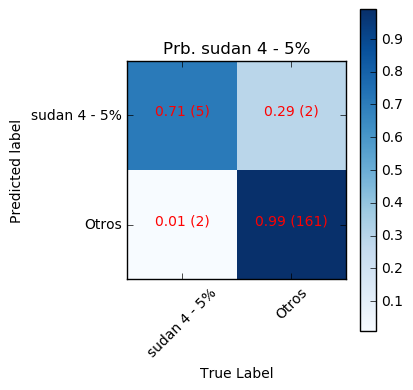

[ 0.97493036  0.98305085  0.97142857]
C-K value: 0.7020157756354075


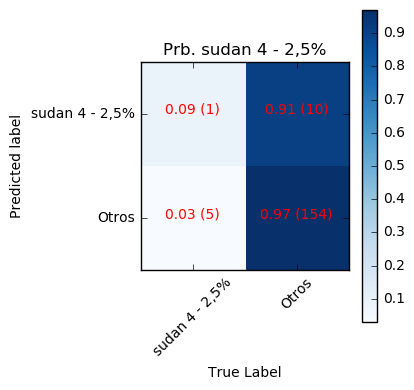

[ 0.95530726  0.95798319  0.94647887]
C-K value: 0.07541696881798399


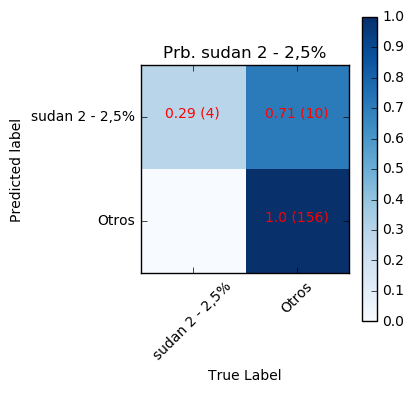

[ 0.91715976  0.96685083  0.96067416]
C-K value: 0.42333785617367703


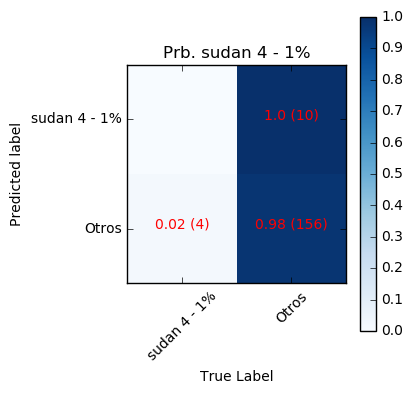

[ 0.95238095  0.96132597  0.92485549]
C-K value: -0.03478260869565197


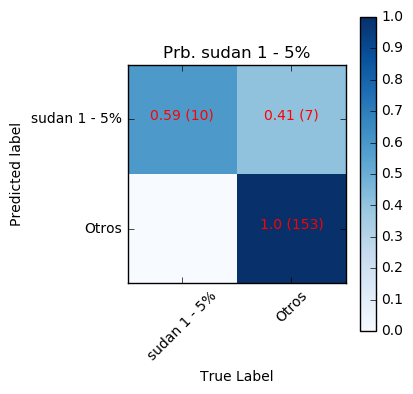

[ 0.98591549  0.77351916  0.98305085]
C-K value: 0.72


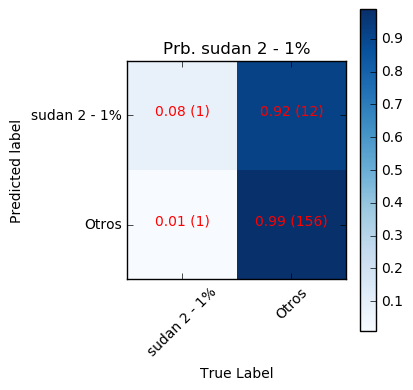

[ 0.94647887  0.96952909  0.91594203]
C-K value: 0.11529223378702969


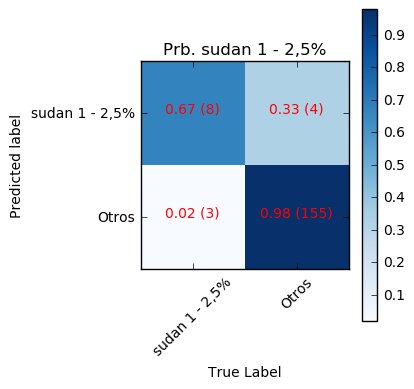

[ 0.97752809  0.91743119  0.997151  ]
C-K value: 0.6736149204607789


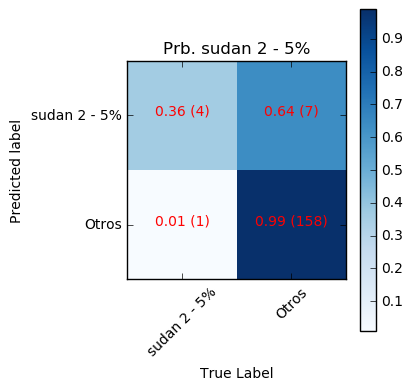

[ 0.97506925  0.98314607  0.97464789]
C-K value: 0.47892720306513403


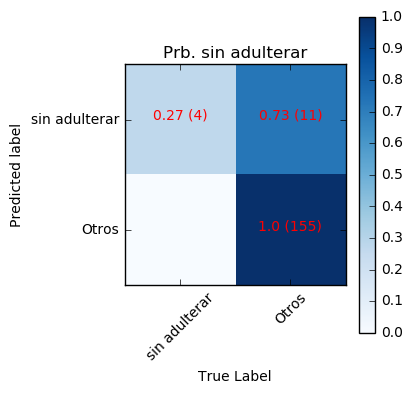

[ 0.97206704  0.86984127  0.96398892]
C-K value: 0.3987138263665595


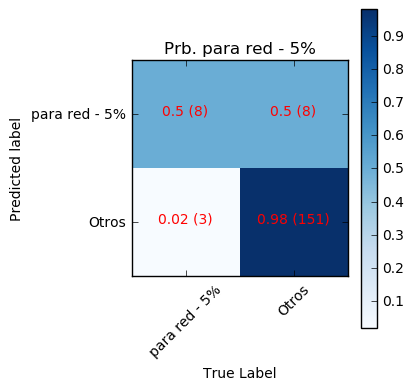

[ 0.97506925  0.95774648  0.95857988]
C-K value: 0.5587541293062765


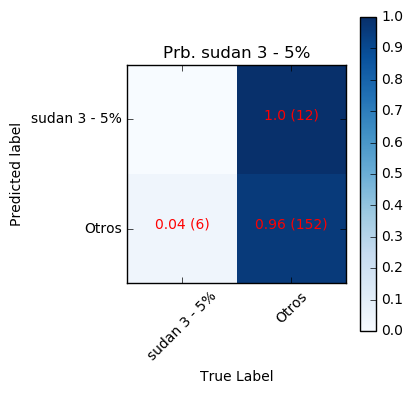

[ 0.93785311  0.94617564  0.95238095]
C-K value: -0.04938271604938271


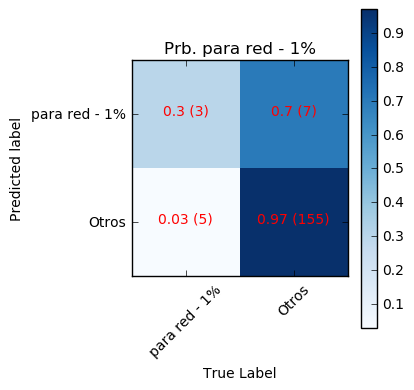

[ 0.94050992  0.95750708  0.97159091]
C-K value: 0.29655172413793107


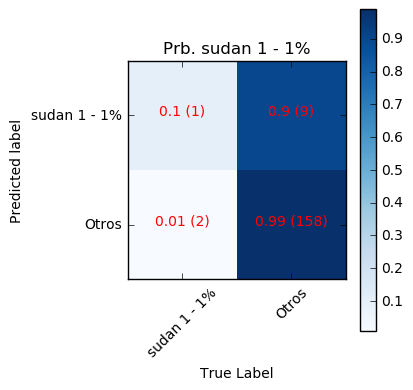

[ 0.95821727  0.9558011   0.95238095]
C-K value: 0.13023255813953494


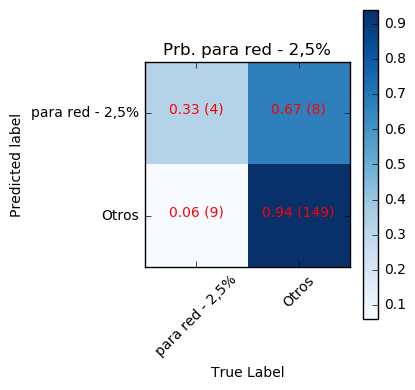

[ 0.9494382   0.95211268  0.93447293]
C-K value: 0.266124936515998


In [19]:
for clase, par in best_params.items():
    target = np.where(data['clase']==clase, 0, 1)
    X_train, X_test, y_train, y_test = train_test_split(normalized, target, test_size=.3, random_state=10)

    clf = RandomForestClassifier(**par["params"])
    clf.n_jobs = 4
    # clf = RandomForestClassifier(max_depth=8, n_jobs=4, n_estimators=40, criterion="entropy", max_features="auto")
    clf.fit(X_train[:, par["features"]], y_train)

    predicted = clf.predict(X_test[:, par["features"]])

    cm = confusion_matrix(y_pred=predicted, y_true=y_test)
    plot_confusion_matrix(classes=[clase, "Otros"], cm=cm, norm=True, title="Prb. {}".format(clase))
    kappa_ = make_scorer(cohen_kappa_score)

    val = cross_val_score(estimator=clf, X=normalized[:, par["features"]], y=target, n_jobs=4, scoring="f1", cv=3)
    print(val)
    print("C-K value: {}".format(cohen_kappa_score(y_test, predicted)))

In [17]:
for k, v in best_params.items():
    print(v)

{'params': {'criterion': 'entropy', 'max_depth': 6, 'max_features': 'log2', 'n_estimators': 20, 'n_jobs': 4}, 'features': array([ 13,  18,  19,  20, 290, 294, 300, 313, 513, 514, 515, 516, 517,
       518, 519, 520, 521, 533, 534, 944])}
{'params': {'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 20, 'n_jobs': 4}, 'features': array([ 85,  86,  87,  88,  89,  90,  91, 168, 169, 255, 256, 257, 258,
       516, 517, 518, 519, 777, 778, 779])}
{'params': {'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'n_estimators': 40, 'n_jobs': 4}, 'features': array([291, 292, 293, 294, 295, 296, 297, 298, 299, 487, 488, 489, 490,
       493, 494, 495, 496, 497, 517, 518])}
{'params': {'criterion': 'entropy', 'max_depth': None, 'max_features': 'auto', 'n_estimators': 20, 'n_jobs': 4}, 'features': array([ 39,  57, 510, 511, 512, 513, 574, 576, 577, 578, 579, 580, 581,
       582, 583, 584, 585, 664, 665, 666])}
{'params': {'criterion': 'entropy', 'max_dept